<a href="https://colab.research.google.com/github/ethangearey/nc-lora/blob/main/Experiment_1%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1+2: Tracking Neural Collapse and Feature Rank (1); Measuring Parameter Update Rank (2)

## Experiment 1
Train deep networks (e.g., ResNet18 on CIFAR-10) with cross-entropy loss.
At each epoch, compute:
- NC metrics (Papyan et al.): NC1-NC4
- Rank of penultimate-layer feature matrix
- Spectrum of singular values (SVD) of class means and classwise features

Goal: empirically track the onset and strength of neural collapse vs. feature-space dimensionality.

## Experiment 2
- Save weight updates over training (e.g., via finite differences or gradients).
- Measure their empirical rank and SVD spectrum.
- Check if late-stage training updates concentrate into a low-rank subspace, coinciding with the emergence of NC.

Goal: evaluate whether global parameter (weight) updates show low-rank at the same time as neural collapse. Ensure that the low-rank parameter updates occur in the classifier and the layer before.


## Implementation Notes

- Finite differences are tracked in UpdateTracker, reflecting momentum effects. Gradients are not tracked in this implementation.

- Checkpointing saves model state, but does not save graphs or UpdateTracker (Experiment 1+2 data) objects due to storage concerns.

- UpdateTracker uses sliding window approach for SVD calculations due to memory issues. Window size can be toggled with max_history parameter.




In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab Notebooks/experiment_data/'
os.makedirs(data_path, exist_ok=True)

overwrite_checkpoint = True

import psutil
import os
import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
from torchvision import datasets, transforms
from IPython import embed
from sklearn.decomposition import IncrementalPCA

debug = True # Only runs 20 batches per epoch for debugging

# Random seed
seed                = 42
torch.manual_seed(seed)
np.random.seed(seed)

# CIFAR dataset parameters
im_size             = 32
padded_im_size      = 32
input_ch            = 3
C                   = 10

# Optimization Criterion
loss_name = 'CrossEntropyLoss'

# Optimization hyperparameters
lr_decay            = 0.1
lr                  = 0.1 # modify?

epochs              = 350
epochs_lr_decay     = [epochs//3, epochs*2//3]

batch_size          = 128

momentum            = 0.9
weight_decay        = 5e-4

# analysis parameters
RANK_THRESHOLDS      = [0.95, 0.99]
tracked_layers      = ['fc.weight', 'layer4.1.conv2.weight']

analysis_epochs          = [1,   2,    4,   5,    7,   8,   10,   11,
                       13,  14,  16,  17,  19,  20,  22,  24,  27,   29,
                       32,  35,  38,  42,  45,  50,  54,  59,  65,  71,   77,
                       85,  92,  101, 110, 121, 132, 144, 158, 172, 188,  206,
                       225, 245, 268, 293, 320, 340, 341, 342, 343, 344, 345,
                       346, 347, 348, 349, 350]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def train(model, criterion, device, num_classes, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(total=len(train_loader), position=0, leave=True)
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        if data.shape[0] != batch_size:
            continue

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        if str(criterion) == 'CrossEntropyLoss()':
          loss = criterion(out, target)

        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(out,dim=1)==target).float()).item()

        pbar.update(1)
        pbar.set_description(
            'Train\t\tEpoch: {} [{}/{} ({:.0f}%)] \t'
            'Batch Loss: {:.6f} \t'
            'Batch Accuracy: {:.6f}'.format(
                epoch,
                batch_idx,
                len(train_loader),
                100. * batch_idx / len(train_loader),
                loss.item(),
                accuracy))

        if debug and batch_idx > 20:
          break
    pbar.close()

In [13]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    all_features = []
    class_features = [[] for _ in range(C)]

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Metrics']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)
            output = model(data)

            h = features.value.data.view(data.shape[0],-1) # B CHW

            # Collect all features for rank analysis
            if computation == 'Mean':
              all_features.append(h.cpu().detach())

            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]

                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                # Collect class-specific features for SVD analysis
                if computation == 'Mean':
                  class_features[c].append(h_c.cpu().detach())

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]

                elif computation == 'Metrics':
                    ## COV
                    # update within-class cov
                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    net_correct += sum(net_pred==target[idxs]).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    NCC_match_net += sum(NCC_pred==net_pred).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))

            if debug and batch_idx > 20:
                break
        pbar.close()

        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
                M = torch.stack(mean).T
            loss /= sum(N)

            # Feature rank analysis
            all_features_tensor = torch.cat(all_features, dim=0)

            # Compute feature rank using *randomized* SVD
            U, S, _ = randomized_svd(all_features_tensor.cpu().numpy(), n_components=100)
            S = torch.from_numpy(S).to(device)

            # Calculate effective rank
            normalized_sv = S / torch.sum(S)
            cumulative_energy = torch.cumsum(normalized_sv, dim=0)
            effective_ranks = {}
            for thresh in RANK_THRESHOLDS:
                effective_ranks[str(thresh)] = (torch.sum(cumulative_energy < thresh) + 1).item() # convert tensor to scalar
            graphs.feature_rank.append(effective_ranks)
            graphs.singular_values.append(S.cpu().numpy())

            # Class means SVD
            U_M, S_M, V_M = torch.svd(M, some=True)
            graphs.mean_singular_values.append(S_M.cpu().numpy())

            # Class-wise SVD analysis
            class_sv_lists = []
            for c in range(C):
                if len(class_features[c]) > 0:
                    class_feat = torch.cat(class_features[c], dim=0)
                    # Center the features
                    class_feat = class_feat - mean[c].unsqueeze(0)
                    # Compute SVD
                    try:
                        _, S_c, _ = torch.svd(class_feat, some=True)
                        class_sv_lists.append(S_c.cpu().numpy())
                    except:
                        # Handle potential numerical issues
                        class_sv_lists.append(np.zeros(min(class_feat.shape)))

            graphs.class_singular_values.append(class_sv_lists)
        elif computation == 'Metrics':
            Sw /= sum(N)

    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1

    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm
    W  = classifier.weight
    M_norms = torch.norm(M_,  dim=0)
    W_norms = torch.norm(W.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # tr{Sw Sb^-1}
    Sw = Sw.cpu().double()
    Sw += 1e-8 * torch.eye(Sw.shape[0], device=Sw.device) # add jitter for numerical sability
    Sb = Sb.cpu().double()  # Extra precision for small eigenvalues; modified orig.
    eigvec, eigval, _ = torch.svd_lowrank(Sb, q=C-1)
    inv_Sb = eigvec @ torch.diag(1/eigval) @ eigvec.T
    graphs.Sw_invSb.append(torch.trace(Sw @ inv_Sb).item())

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    graphs.W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

    # mutual coherence
    def coherence(V):
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W.T/W_norms))


In [14]:
class UpdateTracker:
    def __init__(self, model, max_history=30, max_components=100):
        # Configuration
        self.max_components = max_components
        self.max_history = max_history  # Only keep recent updates to save memory
        self.tracked_layers = tracked_layers
        self.first_update = True

        # Global tracking (all layers)
        self.prev_weights = {n: p.detach().clone() for n, p in model.named_parameters()}
        self.global_deltas = []  # Will use a sliding window approach

        # Layer-specific tracking
        self.layer_prev_weights = {n: model.state_dict()[n].detach().clone()
                                  for n in self.tracked_layers}
        self.layer_deltas = {n: [] for n in self.tracked_layers}

    def compute_update_rank(self, model):
        # Initialize return values
        effective_ranks = {str(t): np.nan for t in RANK_THRESHOLDS}
        effective_ranks_layer = {n: {str(t): np.nan for t in RANK_THRESHOLDS}
                               for n in self.tracked_layers}
        sv = np.full(self.max_components, np.nan)
        layer_svs = {n: np.full(min(self.max_components, model.state_dict()[n].numel()), np.nan)
                    for n in self.tracked_layers}

        # Skip if first epoch
        if self.first_update:
            print("First epoch - initializing trackers (no updates yet)")
            self.first_update = False
            return effective_ranks, sv, effective_ranks_layer, layer_svs

        # === Global computation (all layers) ===
        try:
            # Compute current update
            delta = []
            for n, p in model.named_parameters():
                param_delta = (p.detach() - self.prev_weights[n]).flatten().cpu().numpy()
                delta.append(param_delta)
            delta_vector = np.concatenate(delta)

            # Check if update is too small
            update_norm = np.linalg.norm(delta_vector)
            if update_norm < 1e-10:
                print("Warning: Update magnitude very small, skipping SVD")
                return effective_ranks, sv, effective_ranks_layer, layer_svs

            # Add to history (with memory management)
            self.global_deltas.append(delta_vector)
            if len(self.global_deltas) > self.max_history:
                self.global_deltas.pop(0)  # Remove oldest update

            # Perform SVD on recent history
            delta_matrix = np.vstack(self.global_deltas)
            n_components = min(delta_matrix.shape[0], self.max_components)

            if delta_matrix.shape[0] > 1:
                # Use randomized SVD for efficiency
                U, S, _ = randomized_svd(delta_matrix, n_components=n_components)
                explained_variance = np.cumsum(S**2) / np.sum(S**2)

                # Calculate effective ranks
                for thresh in RANK_THRESHOLDS:
                    effective_ranks[str(thresh)] = np.sum(explained_variance < thresh) + 1
                sv = S.copy()

        except Exception as e:
            print(f"Error in global SVD computation: {e}")
            return effective_ranks, sv, effective_ranks_layer, layer_svs

        # === Layer-specific computation ===
        for layer_name in self.tracked_layers:
            try:
                # Compute current layer update
                current_param = model.state_dict()[layer_name]
                prev_param = self.layer_prev_weights[layer_name]
                layer_delta = (current_param - prev_param).flatten().cpu().numpy().astype(np.float32)  # Use float32 to save memory

                # Check if layer update is too small
                layer_update_norm = np.linalg.norm(layer_delta)
                if layer_update_norm < 1e-10:
                    continue

                # Add to layer history (with memory management)
                self.layer_deltas[layer_name].append(layer_delta)
                if len(self.layer_deltas[layer_name]) > self.max_history:
                    self.layer_deltas[layer_name].pop(0)  # Remove oldest update

                # Perform SVD on recent history for this layer
                if len(self.layer_deltas[layer_name]) > 1:
                    layer_delta_matrix = np.vstack(self.layer_deltas[layer_name])
                    layer_n_components = min(layer_delta_matrix.shape[0], self.max_components)

                    # Use randomized SVD for efficiency
                    _, layer_S, _ = randomized_svd(layer_delta_matrix, n_components=layer_n_components)
                    layer_explained_variance = np.cumsum(layer_S**2) / np.sum(layer_S**2)

                    # Calculate effective ranks for this layer
                    for thresh in RANK_THRESHOLDS:
                        effective_ranks_layer[layer_name][str(thresh)] = np.sum(layer_explained_variance < thresh) + 1
                    layer_svs[layer_name] = layer_S.copy()

            except Exception as e:
                print(f"Error in layer-specific SVD for {layer_name}: {e}")
                continue

        # Update previous weights for next iteration
        self.prev_weights = {n: p.detach().clone() for n, p in model.named_parameters()}
        self.layer_prev_weights = {n: model.state_dict()[n].detach().clone()
                                  for n in self.tracked_layers}

        return effective_ranks, sv, effective_ranks_layer, layer_svs

class Graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []

    # NC4
    self.NCC_mismatch = []

    # Experiment 1 data
    self.feature_rank = [] # stores dict [{'0.95': rank1, '0.99': rank2}
    self.singular_values = []
    self.mean_singular_values = []
    self.class_singular_values = []

    # Global Experiment 2 data
    self.update_ranks = []
    self.update_spectra = []  # Global singular values -- None for most epochs

    # Layer-specific Experiment 2 data
    self.layer_singular_values = {n: [] for n in tracked_layers} #  -- None for most epochs
    self.layer_update_ranks = {n: [] for n in tracked_layers}


Train		Epoch: 1 [21/390 (5%)] 	Batch Loss: 2.496814 	Batch Accuracy: 0.148438:   5%|▌         | 21/390 [03:44<1:05:52, 10.71s/it]


First epoch - initializing trackers (no updates yet)


Analysis Metrics	Epoch: 1 [21/390 (5%)]:   5%|▌         | 21/390 [01:09<20:19,  3.30s/it]
<ipython-input-15-8d6504282a4f>:266: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-15-8d6504282a4f>:289: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


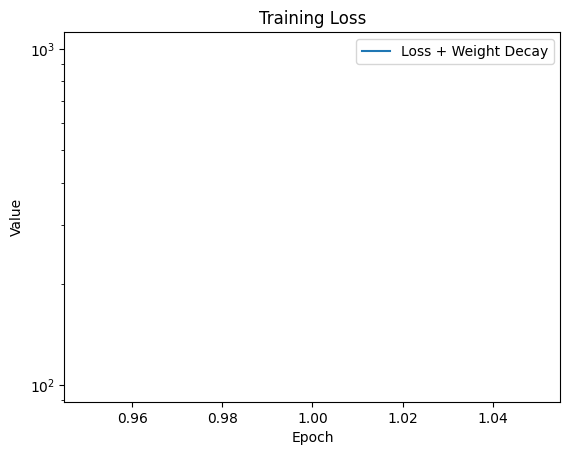

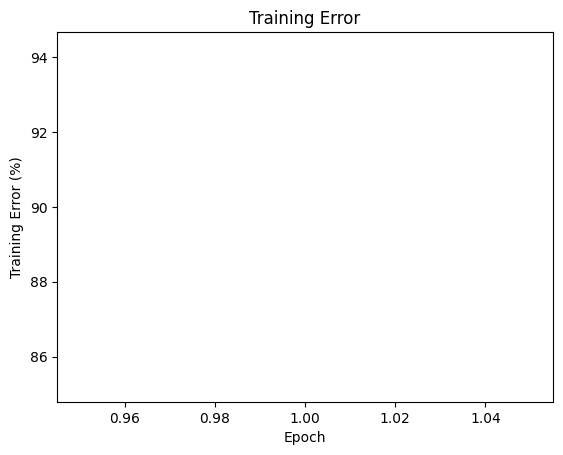

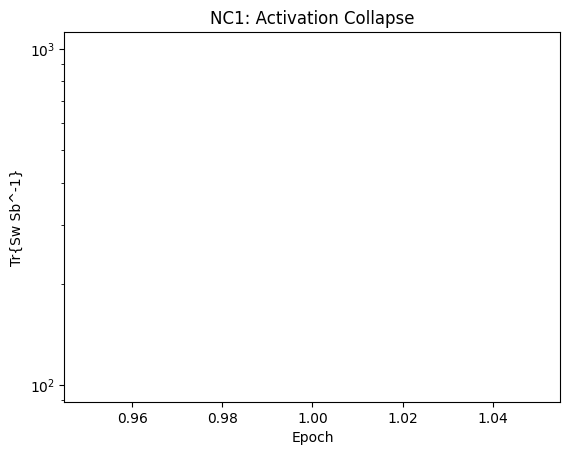

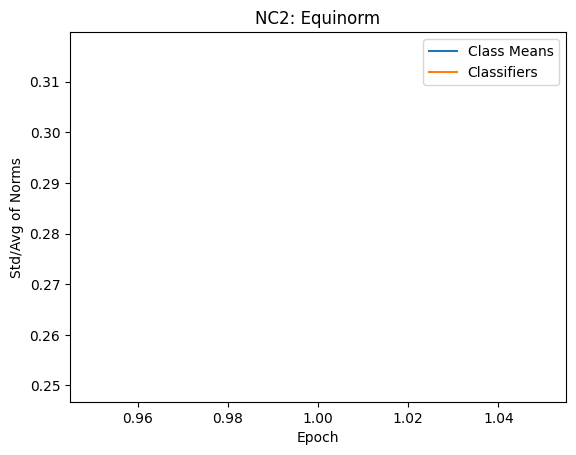

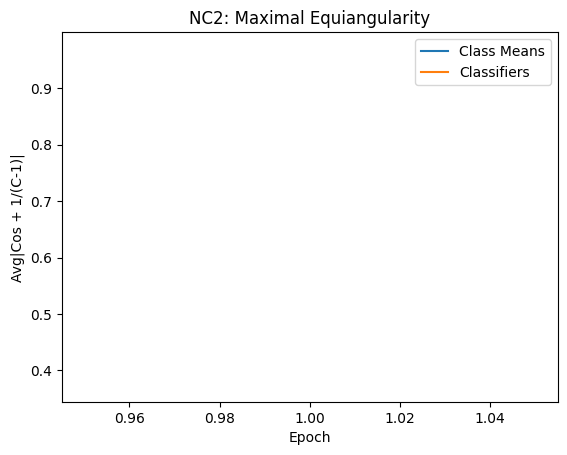

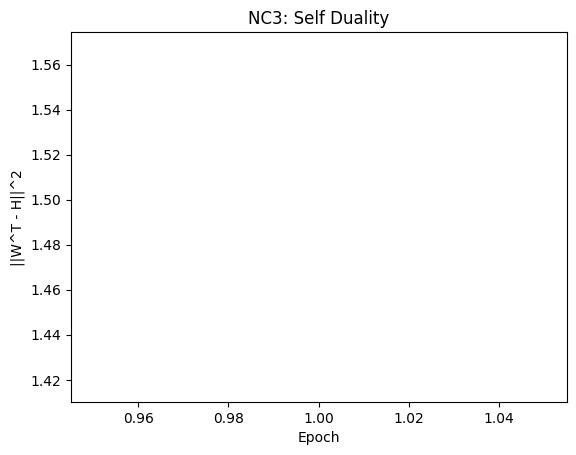

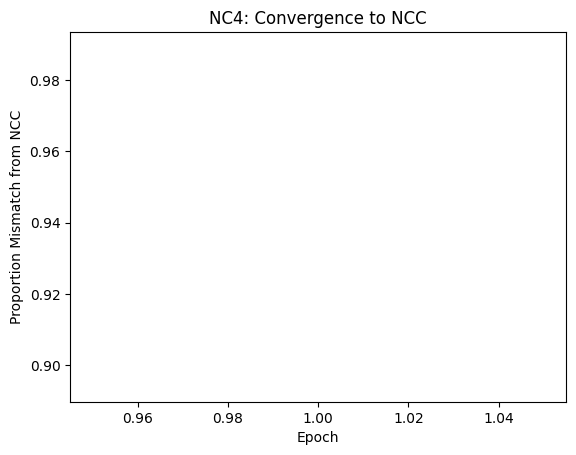

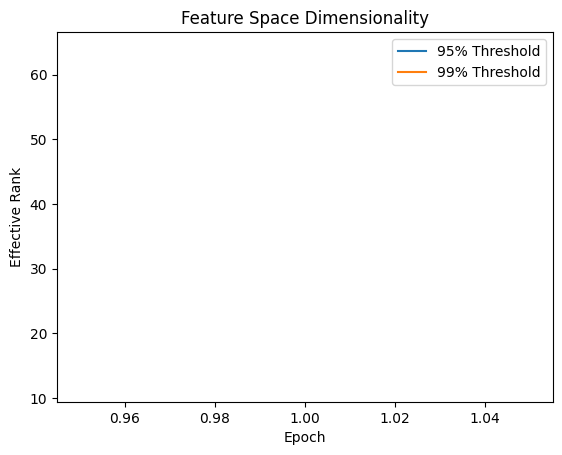

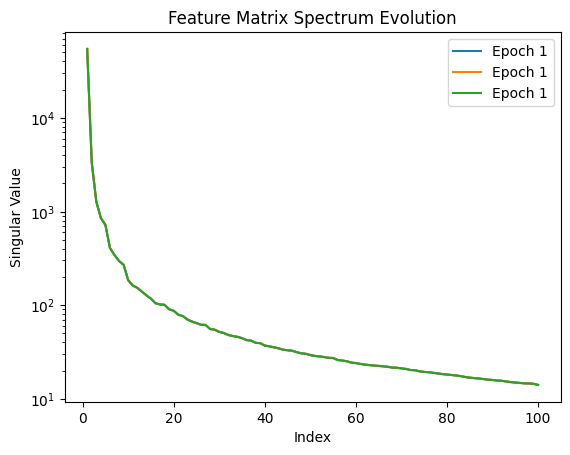

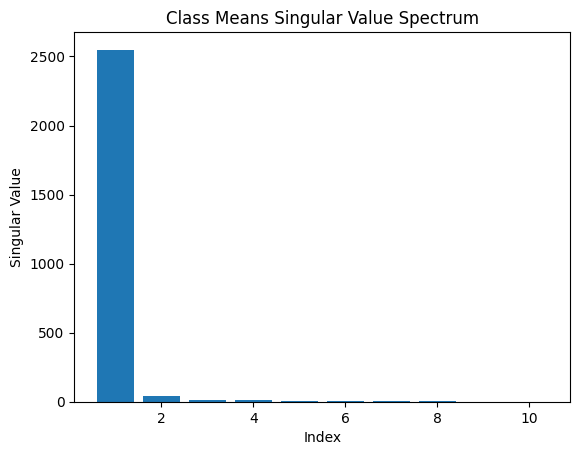

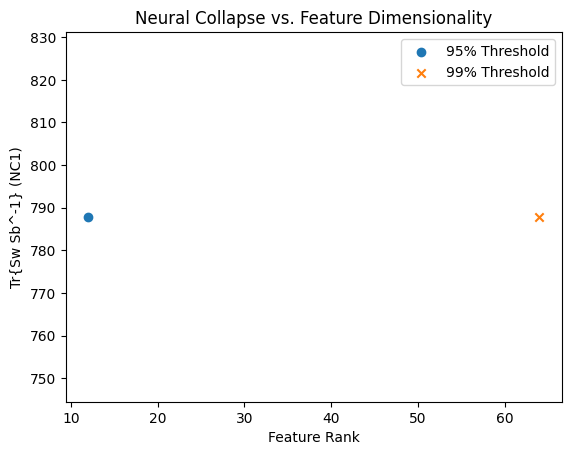

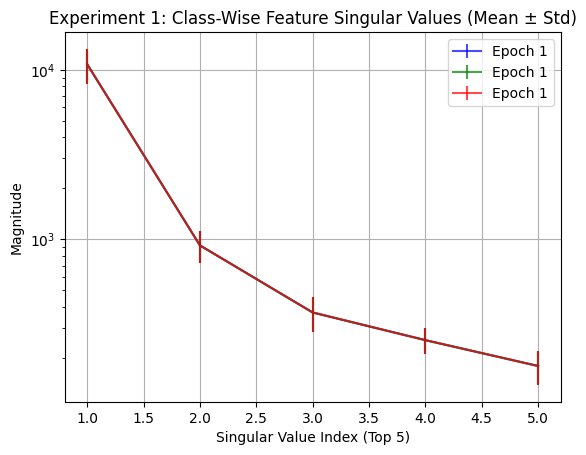

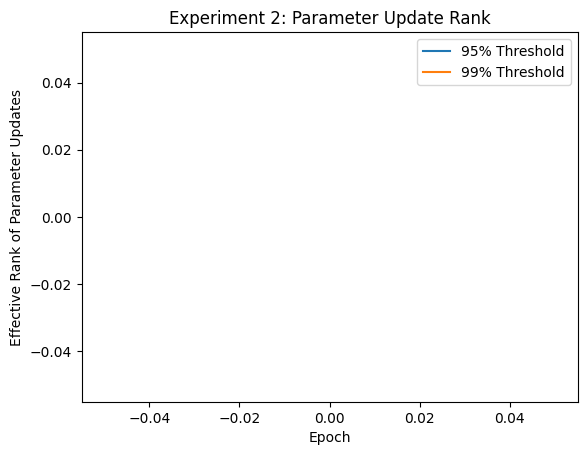

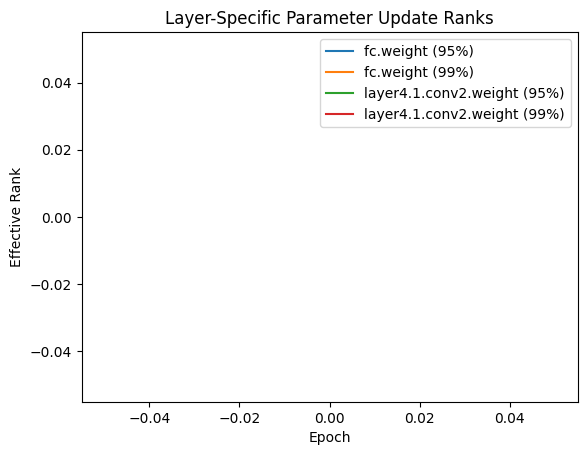

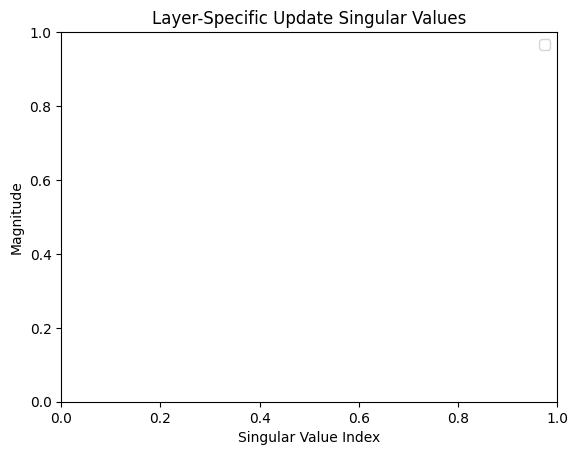

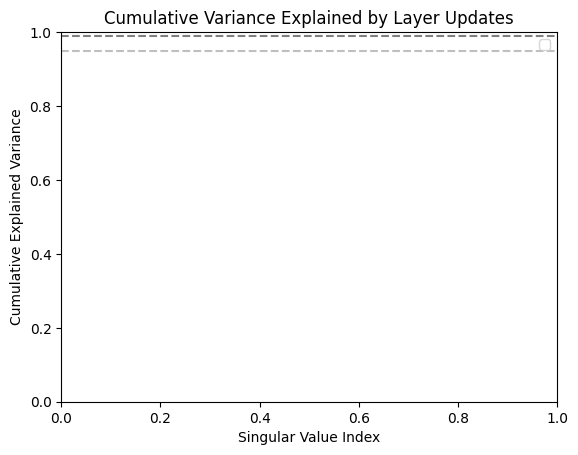

Experiment data saved at epoch 1
Epoch 1: Memory usage: 3155.14 MB
Tracker deltas: 0 updates stored
Checkpoint saved at epoch 1


Train		Epoch: 2 [21/390 (5%)] 	Batch Loss: 2.331970 	Batch Accuracy: 0.101562:   5%|▌         | 21/390 [03:36<1:03:22, 10.30s/it]
Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [01:09<20:12,  3.29s/it]


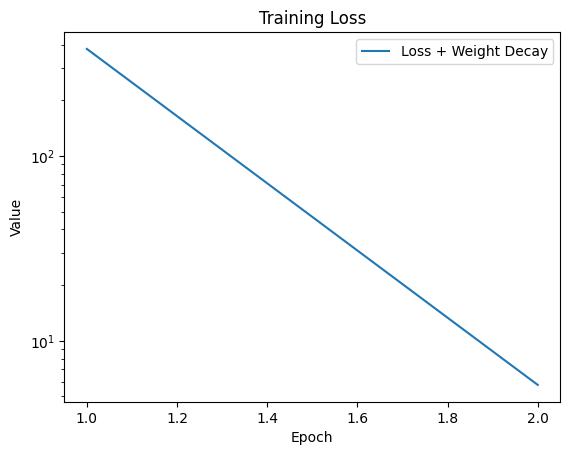

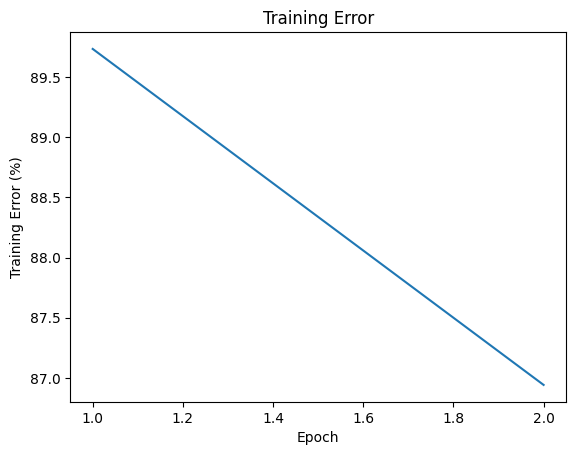

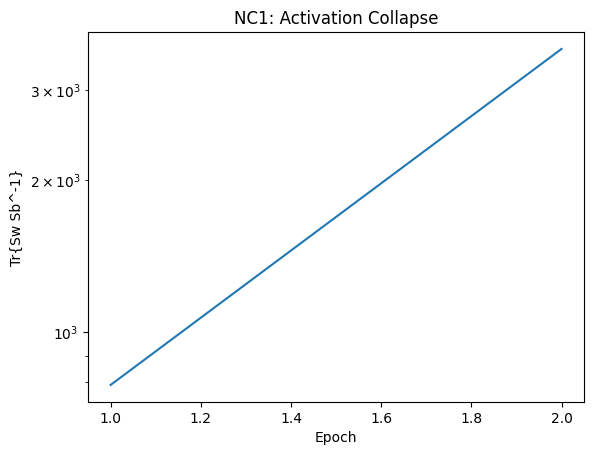

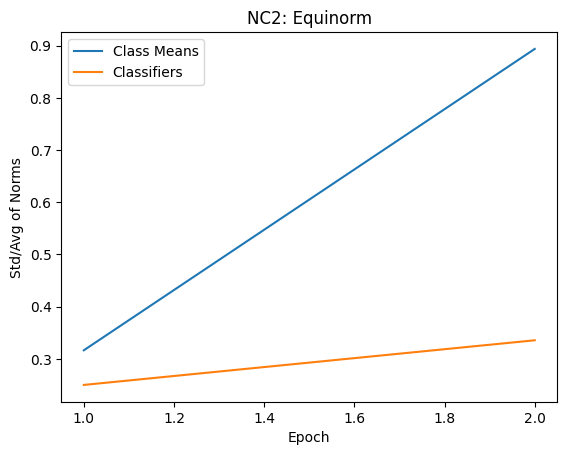

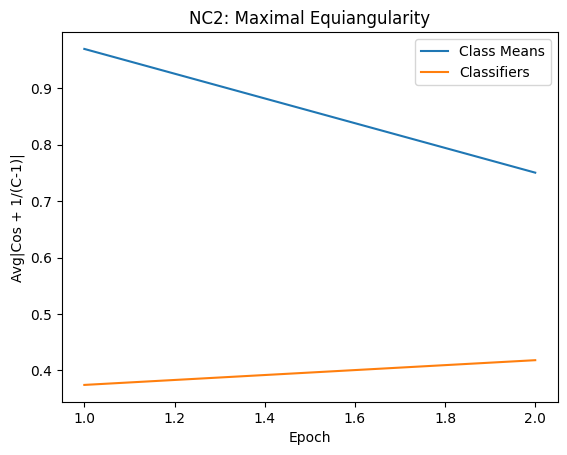

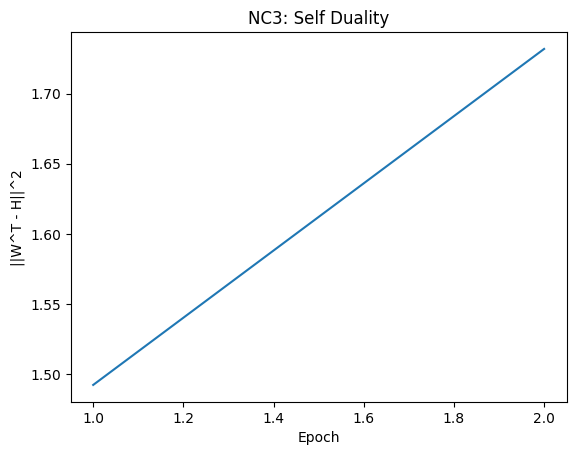

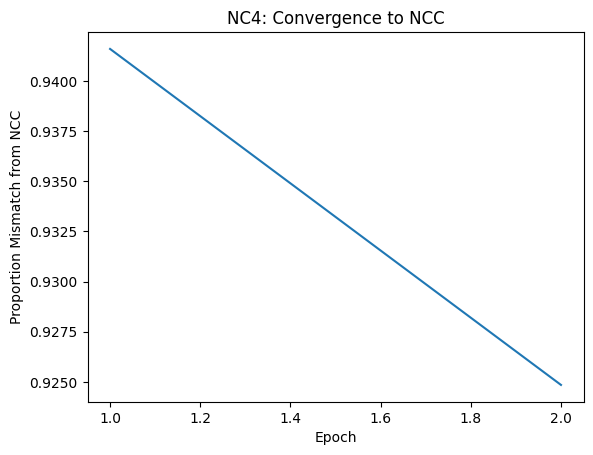

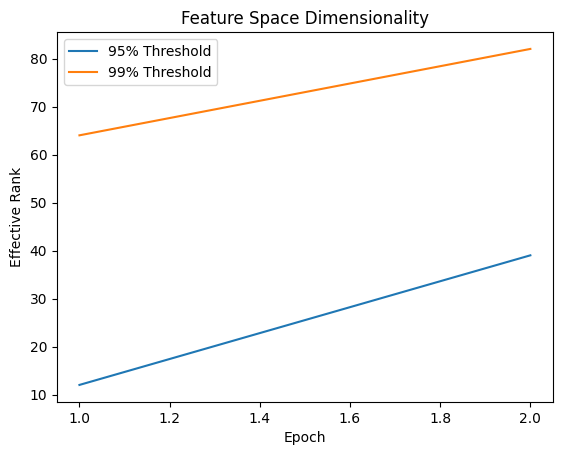

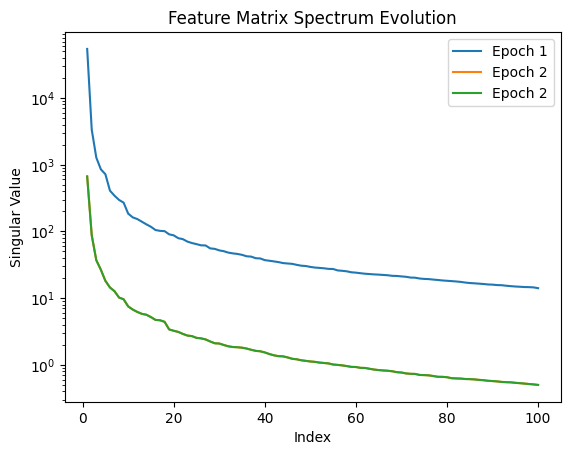

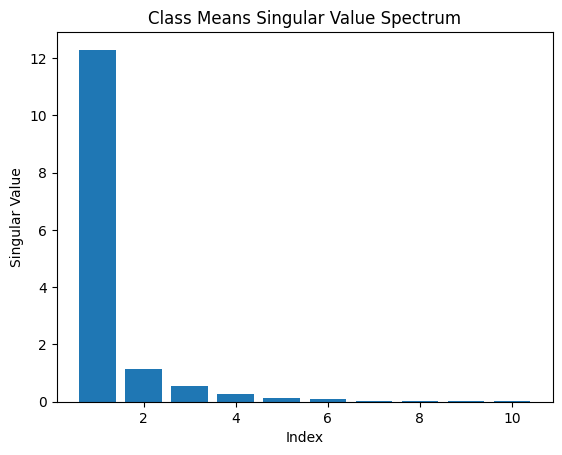

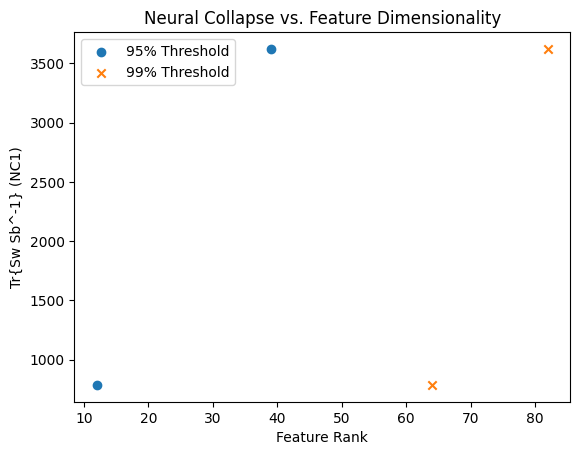

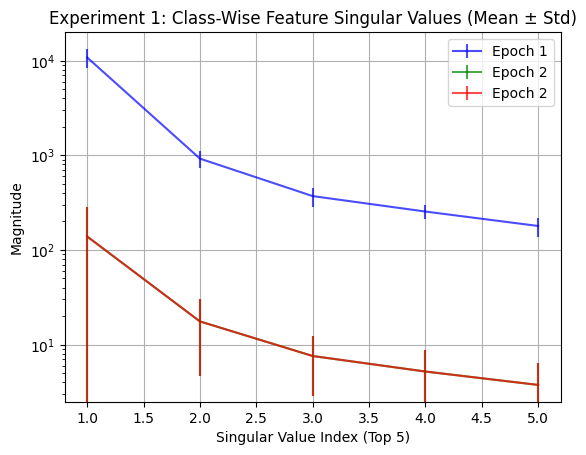

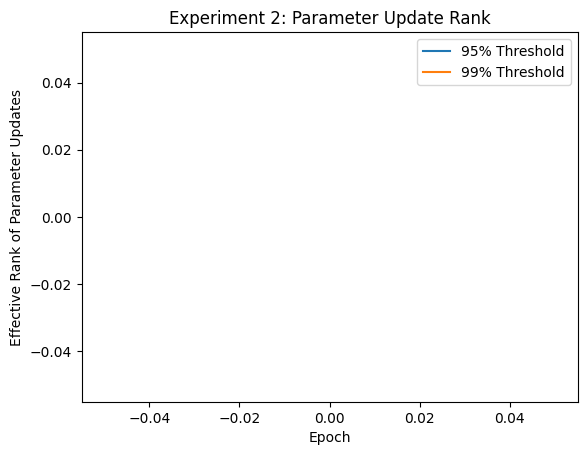

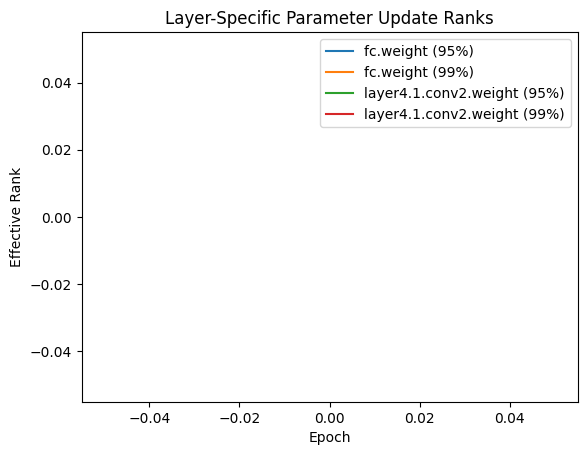

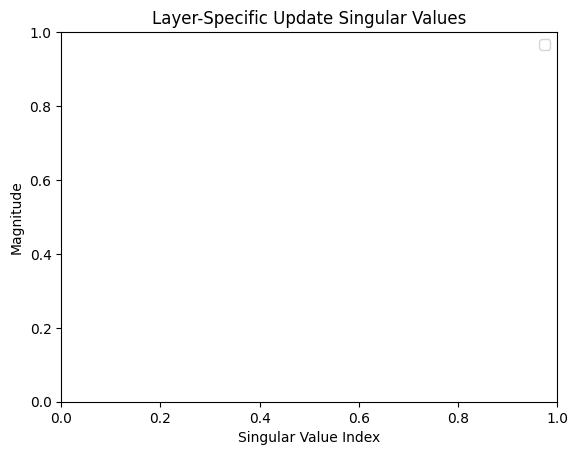

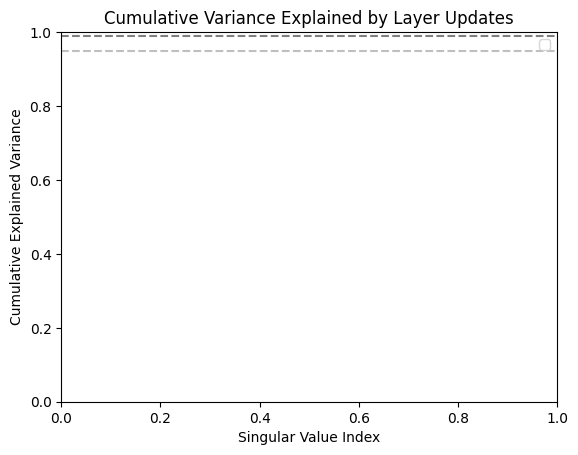

Experiment data saved at epoch 2
Epoch 2: Memory usage: 2899.52 MB
Tracker deltas: 1 updates stored
Checkpoint saved at epoch 2


Train		Epoch: 3 [21/390 (5%)] 	Batch Loss: 2.307213 	Batch Accuracy: 0.117188:   5%|▌         | 21/390 [03:38<1:04:02, 10.41s/it]


Experiment data saved at epoch 3
Epoch 3: Memory usage: 2467.75 MB
Tracker deltas: 2 updates stored
Checkpoint saved at epoch 3


Train		Epoch: 4 [21/390 (5%)] 	Batch Loss: 2.066044 	Batch Accuracy: 0.203125:   5%|▌         | 21/390 [03:44<1:05:46, 10.70s/it]
Analysis Metrics	Epoch: 4 [21/390 (5%)]:   5%|▌         | 21/390 [01:10<20:38,  3.36s/it]


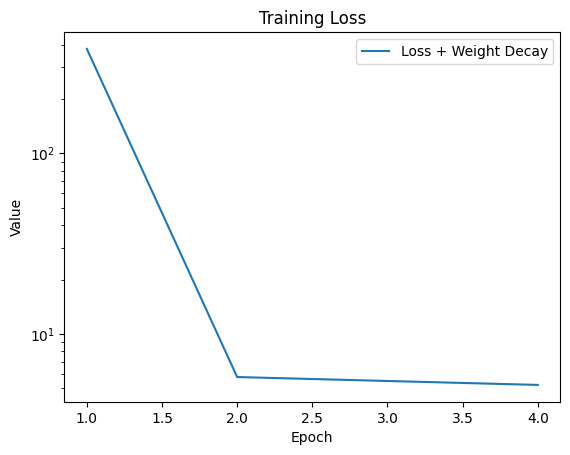

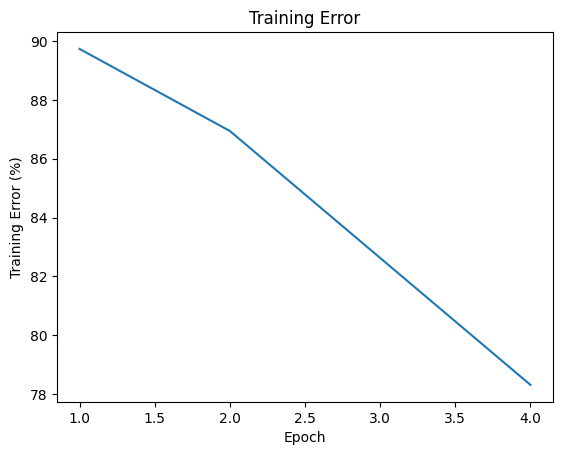

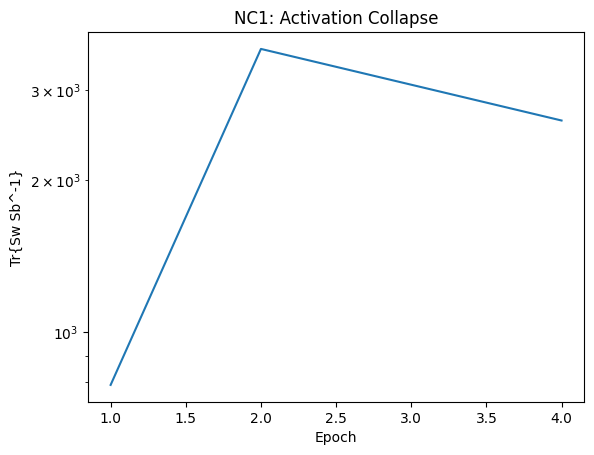

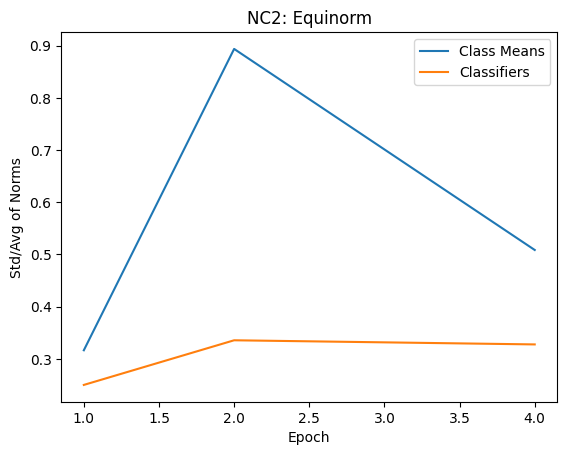

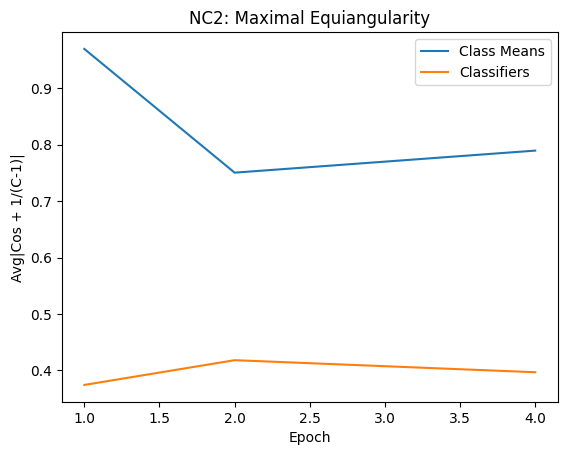

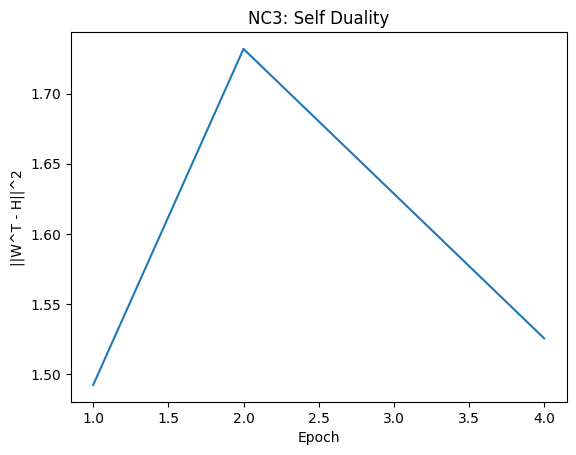

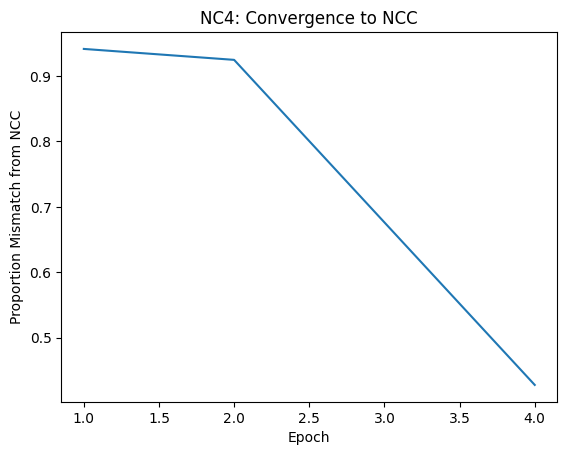

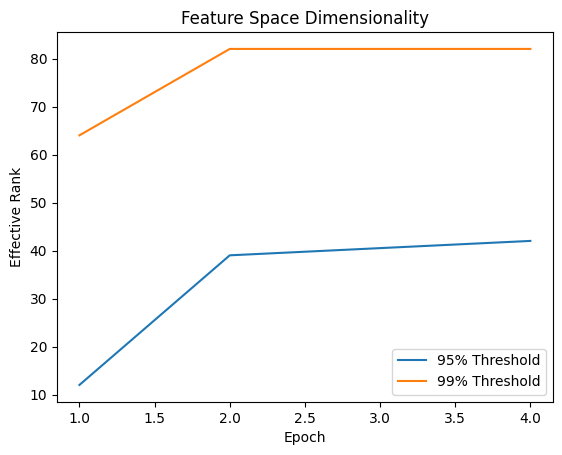

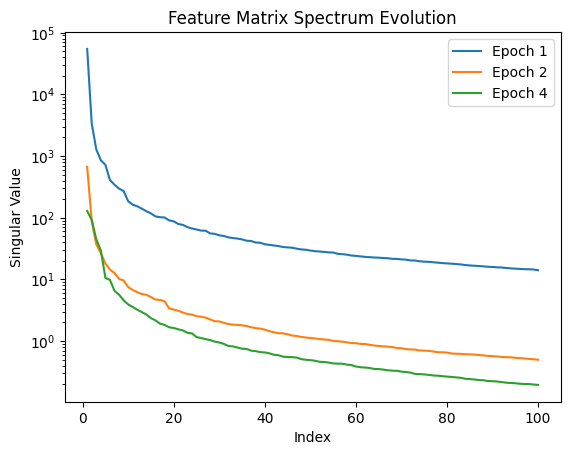

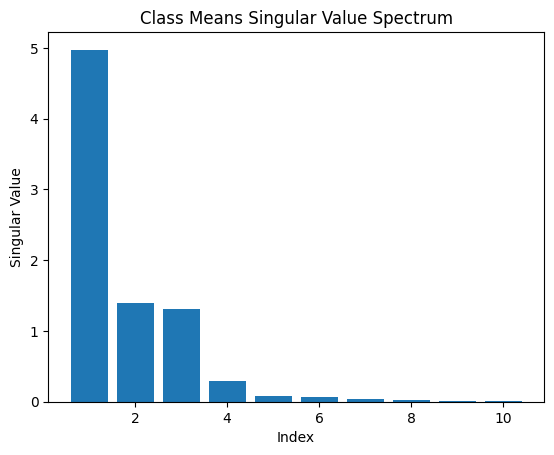

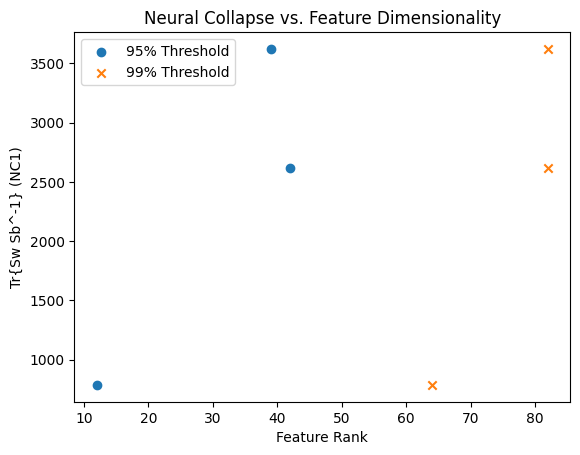

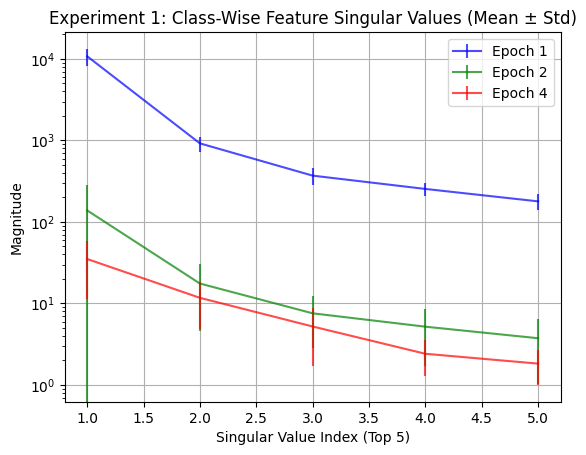

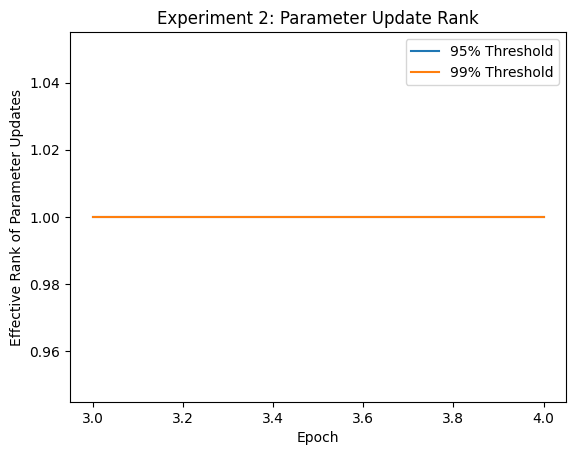

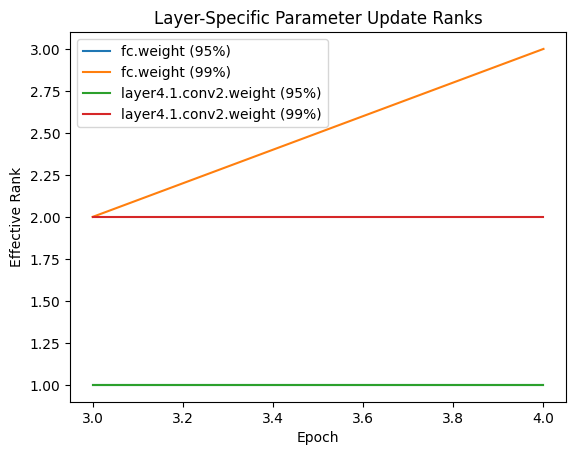

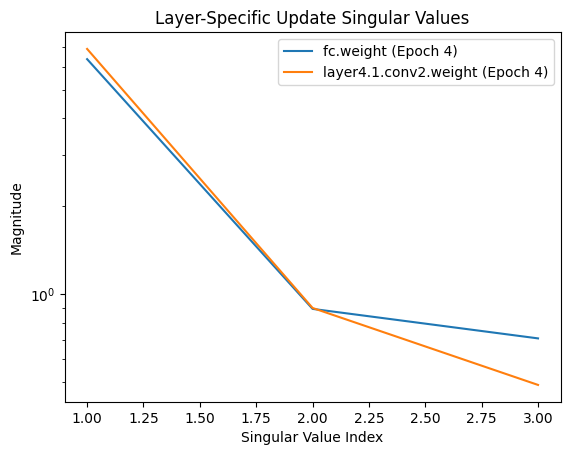

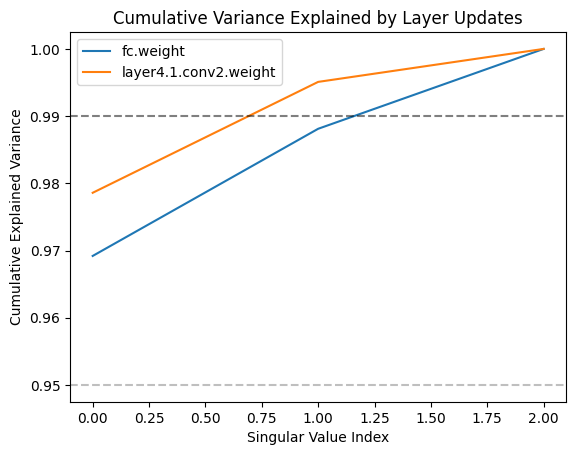

  0%|          | 0/390 [00:00<?, ?it/s]

In [ ]:
model = models.resnet18(pretrained=False, num_classes=C)
model.conv1 = nn.Conv2d(input_ch, model.conv1.weight.shape[0], 3, 1, 1, bias=False) # Small dataset filter size used by He et al. (2015)
model.maxpool = nn.Identity()
model = model.to(device)

class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                ])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

analysis_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

if loss_name == 'CrossEntropyLoss':
  criterion = nn.CrossEntropyLoss()
  criterion_summed = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=lr_decay)
tracker = UpdateTracker(model)
graphs = Graphs()
cur_epochs = []
start_epoch = 1

if not overwrite_checkpoint:
  try:
      checkpoint = torch.load(data_path + 'checkpoint.pth', weights_only=False) # note: only use trusted source (checkpoint from MyDrive)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
      start_epoch = checkpoint['epoch'] + 1
      graphs = checkpoint['graphs']
      cur_epochs = checkpoint['cur_epochs']
      print(f"Resuming from epoch {start_epoch}")
  except FileNotFoundError:
      print("No checkpoint found. Starting from scratch.")


for epoch in range(start_epoch, 11):
    train(model, criterion, device, C, train_loader, optimizer, epoch)
    lr_scheduler.step()


    # === Experiment 2 data collection ===
    update_epochs = list(range(1, epoch + 1)) # used for graphs, data saving
    global_rank, global_sv, layer_ranks, layer_svs = tracker.compute_update_rank(model)
    graphs.update_ranks.append(global_rank)
    for layer_name in tracked_layers:
        graphs.layer_update_ranks[layer_name].append(layer_ranks[layer_name])

    # store spectra only for analysis epochs
    if epoch in analysis_epochs:
        graphs.update_spectra.append(global_sv)
        for layer_name in tracked_layers:
            graphs.layer_singular_values[layer_name].append(layer_svs[layer_name])
    else:
        # Store None as placeholder to maintain index alignment with epoch numbers
        graphs.update_spectra.append(None)
        for layer_name in tracked_layers:
            graphs.layer_singular_values[layer_name].append(None)
            # graphs.layer_update_ranks[layer_name].append({'0.95': np.nan, '0.99': np.nan})


    if epoch in analysis_epochs:
        cur_epochs.append(epoch)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader)

        # === Graphs ===
        ## Experiment 0: NC Figures
        plt.figure(1)
        plt.semilogy(cur_epochs, graphs.reg_loss)
        plt.legend(['Loss + Weight Decay'])
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Training Loss')

        plt.figure(2)
        plt.plot(cur_epochs, 100*(1 - np.array(graphs.accuracy)))
        plt.xlabel('Epoch')
        plt.ylabel('Training Error (%)')
        plt.title('Training Error')

        plt.figure(3)
        plt.semilogy(cur_epochs, graphs.Sw_invSb)
        plt.xlabel('Epoch')
        plt.ylabel('Tr{Sw Sb^-1}')
        plt.title('NC1: Activation Collapse')

        plt.figure(4)
        plt.plot(cur_epochs, graphs.norm_M_CoV)
        plt.plot(cur_epochs, graphs.norm_W_CoV)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Std/Avg of Norms')
        plt.title('NC2: Equinorm')

        plt.figure(5)
        plt.plot(cur_epochs, graphs.cos_M)
        plt.plot(cur_epochs, graphs.cos_W)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Avg|Cos + 1/(C-1)|')
        plt.title('NC2: Maximal Equiangularity')

        plt.figure(6)
        plt.plot(cur_epochs,graphs.W_M_dist)
        plt.xlabel('Epoch')
        plt.ylabel('||W^T - H||^2')
        plt.title('NC3: Self Duality')

        plt.figure(7)
        plt.plot(cur_epochs,graphs.NCC_mismatch)
        plt.xlabel('Epoch')
        plt.ylabel('Proportion Mismatch from NCC')
        plt.title('NC4: Convergence to NCC')

        ## Experiment 1 Figures
        plt.figure(8)
        plt.plot(cur_epochs, [x['0.95'] for x in graphs.feature_rank], label='95% Threshold')
        plt.plot(cur_epochs, [x['0.99'] for x in graphs.feature_rank], label='99% Threshold')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank')
        plt.title('Feature Space Dimensionality')

        plt.figure(9)
        # Plot singular value spectra for selected epochs
        selected_epochs = [0, len(cur_epochs)//2, -1]  # First, middle, last
        for i, epoch_idx in enumerate(selected_epochs):
            if epoch_idx < len(graphs.singular_values):
                sv = graphs.singular_values[epoch_idx]
                plt.semilogy(range(1, len(sv)+1), sv, label=f'Epoch {cur_epochs[epoch_idx]}')
        plt.xlabel('Index')
        plt.ylabel('Singular Value')
        plt.title('Feature Matrix Spectrum Evolution')
        plt.legend()

        plt.figure(10)
        # Plot class means singular values for the last epoch
        if len(graphs.mean_singular_values) > 0:
            sv_means = graphs.mean_singular_values[-1]
            plt.bar(range(1, len(sv_means)+1), sv_means)
            plt.xlabel('Index')
            plt.ylabel('Singular Value')
            plt.title('Class Means Singular Value Spectrum')

        # Correlation between NC metrics and feature rank
        plt.figure(11)
        plt.scatter([x['0.95'] for x in graphs.feature_rank], graphs.Sw_invSb,
            label='95% Threshold')
        plt.scatter([x['0.99'] for x in graphs.feature_rank], graphs.Sw_invSb,
                    label='99% Threshold', marker='x')
        plt.legend()
        plt.xlabel('Feature Rank')
        plt.ylabel('Tr{Sw Sb^-1} (NC1)')
        plt.title('Neural Collapse vs. Feature Dimensionality')

        plt.figure(12)
        selected_epochs = [0, len(cur_epochs)//2, -1]  # First, middle, last epoch
        colors = ['b', 'g', 'r']
        for i, epoch_idx in enumerate(selected_epochs):
            if epoch_idx >= len(graphs.class_singular_values):
                continue
            all_class_svs = graphs.class_singular_values[epoch_idx]

            # Aggregate top-5 SVs across classes
            top5_svs = np.array([sv[:5] for sv in all_class_svs if len(sv) >= 5])
            mean_top5 = np.mean(top5_svs, axis=0)
            std_top5 = np.std(top5_svs, axis=0)

            plt.errorbar(
                range(1, 6), mean_top5, yerr=std_top5,
                label=f'Epoch {cur_epochs[epoch_idx]}', color=colors[i], alpha=0.7
            )

        plt.xlabel('Singular Value Index (Top 5)')
        plt.ylabel('Magnitude')
        plt.yscale('log')
        plt.title('Experiment 1: Class-Wise Feature Singular Values (Mean ± Std)')
        plt.legend()
        plt.grid(True)


        ## Experiment 2 Figures
        plt.figure(13)
        # Filter out NaNs from IPCA early epochs
        valid_global_95 = [
            (e, r['0.95']) for e, r in zip(update_epochs, graphs.update_ranks)
            if '0.95' in r and not np.isnan(r['0.95'])
        ]
        valid_global_99 = [
            (e, r['0.99']) for e, r in zip(update_epochs, graphs.update_ranks)
            if '0.99' in r and not np.isnan(r['0.99'])
        ]
        plt.plot([e for e, _ in valid_global_95], [v for _, v in valid_global_95], label='95% Threshold')
        plt.plot([e for e, _ in valid_global_99], [v for _, v in valid_global_99], label='99% Threshold')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank of Parameter Updates')
        plt.title('Experiment 2: Parameter Update Rank')

        plt.figure(14)
        for layer_name in tracked_layers:
            # Filter NaNs
            valid_95 = [
                (e, r['0.95']) for e, r in zip(update_epochs, graphs.layer_update_ranks[layer_name])
                if '0.95' in r and not np.isnan(r['0.95'])
            ]
            valid_99 = [
                (e, r['0.99']) for e, r in zip(update_epochs, graphs.layer_update_ranks[layer_name])
                if '0.99' in r and not np.isnan(r['0.99'])
            ]
            plt.plot([e for e, _ in valid_95], [v for _, v in valid_95],
                    label=f'{layer_name} (95%)')
            plt.plot([e for e, _ in valid_99], [v for _, v in valid_99],
                    label=f'{layer_name} (99%)')
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank')
        plt.legend()
        plt.title('Layer-Specific Parameter Update Ranks')

        plt.figure(15)
        for layer_name in tracked_layers:
            # Filter out None values and get only epochs in analysis_epochs
            valid_svs = [
                (e, sv) for e, sv in zip(update_epochs, graphs.layer_singular_values[layer_name])
                if sv is not None and not np.isnan(sv).all()
            ]

            if valid_svs:
                # If we have few valid epochs, show all of them
                if len(valid_svs) <= 3:
                    selected_indices = list(range(len(valid_svs)))
                else:
                    # Otherwise show first, middle, last
                    selected_indices = [0, len(valid_svs)//2, -1]

                for idx in selected_indices:
                    e, sv = valid_svs[idx]
                    plt.semilogy(
                        range(1, len(sv)+1), sv,
                        label=f'{layer_name} (Epoch {e})'
                    )
        plt.xlabel('Singular Value Index')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.title('Layer-Specific Update Singular Values')

        plt.figure(16)
        # For the cumulative variance plot, use the last available spectrum for each layer
        for layer_name in tracked_layers:
            # Get non-None values
            valid_svs = [
                sv for sv in graphs.layer_singular_values[layer_name]
                if sv is not None and not np.isnan(sv).all()
            ]

            if valid_svs:
                # Use the last available spectrum
                sv = valid_svs[-1]
                explained_variance = np.cumsum(sv**2) / np.sum(sv**2)
                plt.plot(explained_variance, label=f'{layer_name}')

        for thresh in RANK_THRESHOLDS:
            plt.axhline(thresh, color='k' if thresh==0.99 else 'gray',
                        linestyle='--', alpha=0.5)
        plt.xlabel('Singular Value Index')
        plt.ylabel('Cumulative Explained Variance')
        plt.legend()
        plt.title('Cumulative Variance Explained by Layer Updates')

        plt.show()


    # === Data Save ===
    if epoch in [1, 2, 3, 5, 10, 15, 30, 50, 100, 150, 200, 250, 300, epochs]:
        # Data from analysis epochs
        df = pd.DataFrame({
            'epoch': cur_epochs,
            'Sw_invSb': graphs.Sw_invSb,
            'W_M_dist': graphs.W_M_dist,
            'NCC_mismatch': graphs.NCC_mismatch,
            'norm_M_CoV': graphs.norm_M_CoV,
            'norm_W_CoV': graphs.norm_W_CoV,
            'cos_M': graphs.cos_M,
            'cos_W': graphs.cos_W,
            # Experiment 1
            'feature_rank_95': [x['0.95'] for x in graphs.feature_rank],
            'feature_rank_99': [x['0.99'] for x in graphs.feature_rank],
            # Experiment 2
            'update_rank_95': [graphs.update_ranks[e-1]['0.95'] for e in cur_epochs],
            'update_rank_99': [graphs.update_ranks[e-1]['0.99'] for e in cur_epochs],
            'fc_update_rank_95': [graphs.layer_update_ranks['fc.weight'][e-1]['0.95'] for e in cur_epochs],
            'fc_update_rank_99': [graphs.layer_update_ranks['fc.weight'][e-1]['0.99'] for e in cur_epochs],
            'conv_update_rank_95': [graphs.layer_update_ranks['layer4.1.conv2.weight'][e-1]['0.95'] for e in cur_epochs],
            'conv_update_rank_99': [graphs.layer_update_ranks['layer4.1.conv2.weight'][e-1]['0.99'] for e in cur_epochs]
        })
        df.to_csv(data_path + 'experiment1_experiment2_data.csv', index=False)

        # Save Experiment 1 singular values
        np.save(data_path + 'feature_svs.npy', graphs.singular_values)
        np.save(data_path + 'mean_svs.npy', graphs.mean_singular_values)
        np.save(data_path + 'class_svs.npy', np.array(graphs.class_singular_values, dtype=object))

        # Save Experiment 2 data for all epochs
        df_exp2 = pd.DataFrame({
            'epoch': update_epochs,
            'update_rank_95': [x.get('0.95', np.nan) for x in graphs.update_ranks],
            'update_rank_99': [x.get('0.99', np.nan) for x in graphs.update_ranks],
            'fc_update_rank_95': [x.get('0.95', np.nan) for x in graphs.layer_update_ranks['fc.weight']],
            'fc_update_rank_99': [x.get('0.99', np.nan) for x in graphs.layer_update_ranks['fc.weight']],
            'conv_update_rank_95': [x.get('0.95', np.nan) for x in graphs.layer_update_ranks['layer4.1.conv2.weight']],
            'conv_update_rank_99': [x.get('0.99', np.nan) for x in graphs.layer_update_ranks['layer4.1.conv2.weight']]
        })
        df_exp2.to_csv(data_path + 'experiment2_data.csv', index=False)

        # Experiment 2 singular values (Note: saved as objects due to jagged arrays)
        valid_update_spectra = [sv for sv in graphs.update_spectra if sv is not None]
        np.save(data_path + 'global_update_spectra.npy', np.array(valid_update_spectra, dtype=object))

        for layer_name in tracked_layers:
            valid_layer_svs = [sv for sv in graphs.layer_singular_values[layer_name] if sv is not None]
            np.save(data_path + f'{layer_name}_singular_values.npy', np.array(valid_layer_svs, dtype=object))

        # Save figures
        figures_to_save = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # All
        for fig_num in figures_to_save:
            plt.figure(fig_num)
            plt.savefig(data_path + f'figure_{fig_num}_epoch_{epoch}.pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_num)

        print(f"Experiment data saved at epoch {epoch}")

        # memory usage check
        process = psutil.Process(os.getpid())
        memory_info = process.memory_info()
        print(f"Epoch {epoch}: Memory usage: {memory_info.rss / (1024 * 1024):.2f} MB")
        print(f"Tracker deltas: {len(tracker.global_deltas)} updates stored")

        if torch.cuda.is_available():
            print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

        # save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            # 'graphs': graphs,
            # 'tracker': tracker, # too large; checkpoint for Experiment 3
            'cur_epochs': cur_epochs
        }
        torch.save(checkpoint, data_path + 'checkpoint.pth')
        print(f"Checkpoint saved at epoch {epoch}")
        gc.collect()
        # torch.cuda.empty_cache() # if using GPU

